<a href="https://colab.research.google.com/github/1122iqra/todo/blob/main/Regression_from_scrach(presentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
#---------------------Linear Regression Implementation from Scratch---------------------------
#install basic libraries 

%matplotlib inline  
!pip install mxnet #library for python language,deep learning 
from mxnet import autograd, np, npx #autograd is for automatic differentiation and NP is for multi dimensional-arrays
from d2l import mxnet as d2l #deep learning library 
import mxnet as mx
from mxnet import nd
npx.set_np()
!pip install --upgrade matplotlib #ensure latest version of library is installed 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [100]:
#Generating Data Sets

num_inputs = 2 #it set number of inputs for the linear regression model to 2. In this example, we will use 2 features to predict the labels.
num_examples = 1000 #sets the number of examples in the dataset to 1000. We will generate random data for the features and labels.
true_w = nd.array([0, 0]) #This line initializes the true weights of the linear regression model. We will use these weights to generate the labels.
true_b = 4.2 #This line initializes the true bias of the linear regression model. We will use this bias to generate the labels.
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs)) #This line generates random data for the features using the normal distribution with mean 0 and standard deviation 1. We generate num_examples examples with num_inputs features each
labels = nd.dot(features, true_w) + true_b #This line generates the labels for the linear regression model using the true weights and bias. We use the dot product between the features and weights, and add the bias to generate the labels.
labels += nd.random.normal(scale=0.01, shape=labels.shape) # This line adds some noise to the labels to make the dataset more realistic. We use the normal distribution with mean 0 and standard deviation 0.01 to generate the noise. The noise is added to each label in the dataset.

<ipython-input-101-141dea224315>:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg') #This line sets the format of the matplotlib plots to SVG format. SVG is a vector graphics format that is scalable without losing quality.


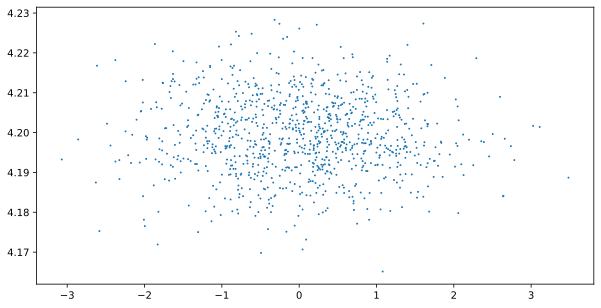

In [101]:
display.set_matplotlib_formats('svg') #This line sets the format of the matplotlib plots to SVG format. SVG is a vector graphics format that is scalable without losing quality.
plt.figure(figsize=(10, 5)) # This line creates a new figure with a size of 6 inches by 3 inches.
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1); #This line creates a scatter plot of the features and labels. We only plot the second feature (column index 1) against the labels. The 1 parameter sets the size of the markers to 1. The asnumpy() method is used to convert the NDArray objects to NumPy arrays, which can be plotted by Matplotlib

In [102]:
#Note 
#The resulting plot should show the relationship between the second feature and the labels.
#Since we used the true weights and bias to generate the labels, there should be a linear relationship between the two. 
#The noise added to the labels should cause some scatter around the line.

In [103]:
#Read the Data 
def data_iter(batch_size, features, labels): #data_iter that creates a generator for iterating through the dataset in mini-batches.(batch-size,feature and labels)
    num_examples = len(features) #The function starts by getting the total number of examples in the dataset, num_examples
    indices = list(range(num_examples)) # creating a list of indices indices that corresponds to each example in the dataset.
   
    # The examples are read at random, in no particular order
    random.shuffle(indices) #shuffles the indices randomly using the shuffle method from the Python random module, so that the examples are read in random order.
    for i in range(0, num_examples, batch_size): #The function then uses a for loop to iterate through the shuffled indices in mini-batches of size batch_size. For each mini-batch, it creates an NDArray j containing the indices for that mini-batch.
        j = nd.array(indices[i: min(i + batch_size, num_examples)]) #, it uses the take method of the features and labels NDArrays to return the features and labels corresponding to the mini-batch, based on the indices in j. The take method returns an NDArray containing the elements of the original NDArray at the specified indices.
        yield features.take(j), labels.take(j) #The yield keyword is used to return the mini-batch of features and labels as a generator object, which can be used in a for loop to iterate through the dataset.
        # The “take” function will then return the corresponding element based # on the indices


In [104]:
#To read the data in sequential order instead of random order, you can remove the line random.shuffle(indices) from the data_iter function. This will cause the function to iterate over the examples in the order they appear in the features and labels arrays. The modified data_iter function would look like this:

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)
#Note that iterating over the examples in sequential order may result in slower convergence during training, as the model may not see a representative sample of the data at each iteration. Randomizing the order of examples can help to ensure that the model sees a diverse range of examples during training.

In [105]:
#Print a Small Data Batch

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
  print(X, y)
  break



[[-0.9669159  -0.38354877]
 [-0.9567186   1.3099662 ]
 [-0.01892485 -1.1338538 ]
 [-1.1448301  -0.9327971 ]
 [-1.5246642   1.3233095 ]
 [ 0.9878486  -0.05733065]
 [-1.0394957   0.6635614 ]
 [-0.8773337  -0.55512375]
 [ 0.4156301   1.884413  ]
 [-0.2921717   1.4377805 ]]
<NDArray 10x2 @cpu(0)> 
[4.197171  4.1918344 4.1777315 4.1966004 4.2032337 4.1948423 4.205639
 4.1969323 4.213729  4.1951275]
<NDArray 10 @cpu(0)>


In [106]:
#Initialize Model Parameters

w = nd.random.normal(scale=0.01, shape=(num_inputs, 1)) #The code first initializes the weight parameter w as a random matrix with shape (num_inputs, 1), where each element is drawn from a normal distribution with mean 0 and standard deviation 0.01.
b = nd.zeros(shape=(1,)) #The bias parameter b is initialized as a zero-dimensional array with shape (1,), which is effectively a scalar value

In [107]:
#Attach Gradients to Parameters

w.attach_grad()
b.attach_grad()
#After initializing the parameters w and b with their respective values, we call attach_grad() on them to allocate memory to store gradients computed during backpropagation. This is because we want to optimize the values of these parameters during training to minimize the loss function
#If we do not initialize gradients for the parameters of a neural network, such as the weight and bias parameters, the framework will not be able to compute the gradients during backpropagation.
#During training, the neural network updates its parameters by computing gradients of the loss function with respect to these parameters and using an optimization algorithm to adjust their values. If we do not initialize gradients for the parameters, the optimization algorithm will not be able to compute the updates necessary to improve the model's performance.

In [108]:
#Define the Linear Model

def linreg(X, w, b):
   return nd.dot(X, w) + b

#This code defines a linear regression function that takes in three arguments:
#X: a matrix representing the input data with shape (batch_size, num_inputs)
#w: a weight matrix with shape (num_inputs, 1)
#b: a bias parameter with shape (1,)
#The function computes the linear combination of X, w, and b by taking the dot product of X and w, then adding b. This can be represented mathematically as:
#y_hat = Xw + b
#where y_hat is the predicted output of the linear regression model.
#The function uses the nd module in MXNet to perform matrix multiplication and addition efficiently on multi-dimensional arrays.
#The output of this function y_hat will have shape (batch_size, 1) since we are multiplying a (batch_size, num_inputs) matrix with a (num_inputs, 1) matrix, and then adding a scalar value b.

In [109]:
#Define the Loss Function

def squared_loss(y_hat, y):
  return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

#This code defines a loss function for a regression problem called squared loss. The loss function takes in two arguments:
#y_hat: the predicted output of the regression model, with shape (batch_size, 1)
#y: the true output or label, with shape (batch_size,)
#The function first reshapes y to have the same shape as y_hat using y.reshape(y_hat.shape). This is done to ensure that y_hat and y have the same shape so that we can compute the element-wise difference between them.
#The squared loss function computes the mean squared error between y_hat and y, which is a commonly used loss function in regression problems. Mathematically, it can be represented as:
#L = (1/batch_size) * sum((y_hat - y) ** 2)
#where L is the mean squared error loss, batch_size is the number of examples in the training batch, and sum represents the sum of all the elements in the vector.

In [110]:
#Define the Optimization Algorithm

def sgd(params, lr, batch_size): 
  for param in params:
    param[:] = param - lr * param.grad / batch_size
#This code defines a stochastic gradient descent (SGD) optimization algorithm for updating the parameters of a neural network during training. The function takes in three arguments:
#params: a list of parameters for the neural network, with each parameter represented as an ndarray with a shape of (num_inputs, 1) or (1,)
#lr: the learning rate, which controls the step size taken in each iteration of the optimization algorithm
#batch_size: the number of examples in each training batch
#The SGD algorithm updates the parameters by computing the gradients of the loss function with respect to the parameters using backpropagation. For each parameter param, the algorithm updates its value using the following formula:
#param = param - lr * param.grad / batch_size
#where lr is the learning rate, param.grad is the gradient of the loss function with respect to the parameter param, and batch_size is the number of examples in the training batch.
#The [:] operator is used to update the value of param in place, rather than creating a new ndarray with the updated values. This helps to save memory during training.

In [111]:
#TRAINING

lr = 0.1 # Learning rate
num_epochs = 3 # Number of iterations
net = linreg # Our fancy linear model
loss = squared_loss # 0.5 (y-y')^2
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))
w.attach_grad()
b.attach_grad()

for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    with autograd.record():
      l = loss(net(X, w, b), y) # Minibatch loss in X and y
    l.backward() # Compute gradient on l with respect to [w,b]
    sgd([w, b], lr, batch_size) # Update parameters using their gradient 
  train_l = loss(net(features, w, b), labels)
  print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))


epoch 1, loss 0.000050
epoch 2, loss 0.000050
epoch 3, loss 0.000050


In [112]:
#EVALUATE THE MODEL

print('Error in estimating w', true_w - w.reshape(true_w.shape))
print('Error in estimating b', true_b - b)
print(w)
print(b)

Error in estimating w 
[0.00049242 0.00178115]
<NDArray 2 @cpu(0)>
Error in estimating b 
[0.0002265]
<NDArray 1 @cpu(0)>

[[-0.00049242]
 [-0.00178115]]
<NDArray 2x1 @cpu(0)>

[4.1997733]
<NDArray 1 @cpu(0)>


In [113]:
#Q8 part 1:Absoulte value loss

def abs_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)).abs().sum()

lr = 0.1
num_epochs = 10
net = linreg
loss = abs_loss
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))
w.attach_grad()
b.attach_grad()

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)
        l.backward()
        sgd([w, b], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))


epoch 1, loss 43.919392
epoch 2, loss 33.524242
epoch 3, loss 64.548561
epoch 4, loss 31.536757
epoch 5, loss 82.875137
epoch 6, loss 38.808441
epoch 7, loss 48.285923
epoch 8, loss 41.762516
epoch 9, loss 68.661041
epoch 10, loss 36.957546


In [114]:
#PART 2
features = nd.random.normal(scale=1, shape=(1000, 2))
true_w = nd.array([[2], [-3.4]])
true_b = nd.array([4.2])
labels = nd.dot(features, true_w) + true_b
labels += .01 * nd.random.normal(scale=1, shape=labels.shape)

lr = 0.1
num_epochs = 10
net = linreg
loss = abs_loss
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))
w.attach_grad()
b.attach_grad()

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)
        l.backward()
        sgd([w, b], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))


epoch 1, loss 41.593006
epoch 2, loss 60.531139
epoch 3, loss 61.440258
epoch 4, loss 61.695656
epoch 5, loss 18.393896
epoch 6, loss 60.169777
epoch 7, loss 17.509340
epoch 8, loss 60.194798
epoch 9, loss 80.277214
epoch 10, loss 41.870388


In [115]:
#PART #
features = nd.random.normal(scale=1, shape=(1000, 2))
true_w = nd.array([[2], [-3.4]])
true_b = nd.array([4.2])
labels = nd.dot(features, true_w) + true_b
labels += .01 * nd.random.normal(scale=1, shape=labels.shape)
labels[5] = 10000

lr = 0.1
num_epochs = 10
net = linreg
loss = abs_loss
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))
w.attach_grad()
b.attach_grad()

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)
        l.backward()
        sgd([w, b], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))


epoch 1, loss 10060.581055
epoch 2, loss 10039.956055
epoch 3, loss 10042.770508
epoch 4, loss 10053.102539
epoch 5, loss 10023.887695
epoch 6, loss 10056.860352
epoch 7, loss 10051.110352
epoch 8, loss 10029.711914
epoch 9, loss 10041.817383
epoch 10, loss 10013.166016


In [116]:
from d2l import mxnet as d2l
from mxnet import autograd, np, npx
npx.set_np()

true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

def train(features, labels, batch_size, lr, num_epochs):
    net = lambda X: d2l.linreg(X, w, b)
    loss = d2l.huber_loss
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs], ylim=[0.0, 0.5])
    for epoch in range(num_epochs):
        for X, y in d2l.data_iter(batch_size, features, labels):
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, d2l.evaluate_loss(net, features, labels, loss))
    print('Error in estimating w:', true_w - w.reshape(true_w.shape))
    print('Error in estimating b:', true_b - b)
    return

batch_size, lr, num_epochs = 10, 0.01, 100
w = np.random.normal(0, 0.01, size=(2, 1))
b = np.zeros(1)
train(features, labels, batch_size, lr, num_epochs)


AttributeError: ignored